In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm

# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(gpus) > 0}")

# Define paths
DATA_PATH = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset"
VIOLENT_PATH = os.path.join(DATA_PATH, "Violence")
NON_VIOLENT_PATH = os.path.join(DATA_PATH, "NonViolence")

# Check if dataset exists
if os.path.exists(DATA_PATH):
    print(f"Violent videos: {len(os.listdir(VIOLENT_PATH))}")
    print(f"Non-violent videos: {len(os.listdir(NON_VIOLENT_PATH))}")
else:
    print(f"Dataset does not exist at {DATA_PATH}")

TensorFlow version: 2.17.1
GPU available: True
Violent videos: 1000
Non-violent videos: 1000


In [2]:
from tensorflow.keras import layers
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()  # Add this decorator to make the layer serializable
class ExtractFrame(layers.Layer):
    def __init__(self, frame_index, **kwargs):
        super(ExtractFrame, self).__init__(**kwargs)
        self.frame_index = frame_index
    
    def call(self, inputs):
        return inputs[:, self.frame_index]
    
    def get_config(self):
        config = super(ExtractFrame, self).get_config()
        config.update({"frame_index": self.frame_index})
        return config

In [3]:
def extract_frames(video_path, num_frames=16):
    """Extract evenly spaced frames from a video file"""
    frames = []
    cap = cv2.VideoCapture(video_path)
    
    # Get total frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame indices to extract (evenly spaced)
    if total_frames <= num_frames:
        frame_indices = list(range(total_frames))
    else:
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count in frame_indices:
            # Convert to RGB (from BGR) and resize
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        
        frame_count += 1
    
    cap.release()
    
    # Ensure we have exactly num_frames
    while len(frames) < num_frames:
        # Duplicate the last frame if needed
        frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))
    
    return np.array(frames)

def visualize_frames(frames, title="Video Frames"):
    """Visualize extracted frames"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(frames):
            ax.imshow(frames[i])
            ax.set_title(f"Frame {i}")
            ax.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def preprocess_frame(frame):
    """Preprocess a single frame for model input using ImageNet normalization"""
    # Convert to float and scale to [0, 1]
    frame = frame.astype(np.float32) / 255.0
    
    # Normalize according to ImageNet stats
    frame -= np.array([0.485, 0.456, 0.406])
    frame /= np.array([0.229, 0.224, 0.225])
    
    return frame
class CrimeDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=4, num_frames=16, shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.video_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        # Calculate start and end indices for the current batch
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.video_paths))
        batch_indexes = self.indexes[start_idx:end_idx]
        
        batch_videos = []
        batch_labels = []
        
        for i in batch_indexes:
            # Extract and preprocess frames
            frames = extract_frames(self.video_paths[i], self.num_frames)
            frames = np.array([preprocess_frame(frame) for frame in frames])
            batch_videos.append(frames)
            
            # One-hot encode labels
            label = to_categorical(self.labels[i], num_classes=2)
            batch_labels.append(label)
            
        return np.array(batch_videos), np.array(batch_labels)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.video_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

def create_data_generators(violent_path, non_violent_path, batch_size=4, val_split=0.2):
    """Create train and validation data generators"""
    # Get all video paths and labels
    violent_videos = [os.path.join(violent_path, f) for f in os.listdir(violent_path) if f.endswith(('.mp4', '.avi'))]
    non_violent_videos = [os.path.join(non_violent_path, f) for f in os.listdir(non_violent_path) if f.endswith(('.mp4', '.avi'))]
    
    all_videos = violent_videos + non_violent_videos
    all_labels = [1] * len(violent_videos) + [0] * len(non_violent_videos)
    
    # Shuffle with a fixed seed for reproducibility
    indices = np.arange(len(all_videos))
    np.random.seed(42)  # Added for reproducibility
    np.random.shuffle(indices)
    np.random.seed(None)  # Reset seed
    
    all_videos = [all_videos[i] for i in indices]
    all_labels = [all_labels[i] for i in indices]
    
    # Split into train and validation
    val_size = int(val_split * len(all_videos))
    train_videos = all_videos[val_size:]
    train_labels = all_labels[val_size:]
    val_videos = all_videos[:val_size]
    val_labels = all_labels[:val_size]
    
    # Create generators
    train_generator = CrimeDataGenerator(train_videos, train_labels, batch_size=batch_size)
    val_generator = CrimeDataGenerator(val_videos, val_labels, batch_size=batch_size, shuffle=False)
    
    return train_generator, val_generator, (len(train_videos), len(val_videos))


In [4]:
def create_trn_model(num_frames=16, num_classes=2):
    """Create Temporal Relation Network model in TensorFlow with serializable architecture"""
    # Input layer for frames sequence
    input_frames = layers.Input(shape=(num_frames, 224, 224, 3), name='input_frames')
    
    # Feature extractor - using ResNet50 as base
    base_model = applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model layers (fine-tune later if needed)
    for layer in base_model.layers:
        layer.trainable = False
    
    # Process each frame through the base model
    encoded_frames = []
    for i in range(num_frames):
        # Use custom layer instead of Lambda
        frame = ExtractFrame(frame_index=i, name=f'extract_frame_{i}')(input_frames)
        x = base_model(frame)
        x = layers.GlobalAveragePooling2D(name=f'gap_{i}')(x)
        encoded_frames.append(x)
    
    # Combine encoded frames
    reshaped_frames = [layers.Reshape((1, -1), name=f'reshape_{i}')(frame) for i, frame in enumerate(encoded_frames)]
    combined_features = layers.Concatenate(axis=1, name='combine_features')(reshaped_frames)
    
    # Multi-scale temporal relations
    temporal_scales = [2, 3, 4, 5]
    temporal_outputs = []
    
    # TRN module - each scale with unique name
    for j, scale in enumerate(temporal_scales):
        x = layers.Conv1D(
            filters=256, kernel_size=scale, strides=1, padding='valid',
            name=f'temporal_conv_{scale}'
        )(combined_features)
        x = layers.BatchNormalization(name=f'bn_{scale}')(x)
        x = layers.Activation('relu', name=f'relu_{scale}')(x)
        x = layers.GlobalMaxPooling1D(name=f'global_max_{scale}')(x)
        temporal_outputs.append(x)
    
    # Concatenate multi-scale features
    x = layers.Concatenate(name='concat_temporal')(temporal_outputs)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.Dropout(0.5, name='dropout')(x)
    
    # Final classification
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model - explicitly using Model class for better serialization
    model = models.Model(inputs=input_frames, outputs=outputs, name='TRN_model')
    return model
def train_model(model, train_generator, val_generator, train_size, val_size, num_epochs=10, learning_rate=0.0001):
    """Train and evaluate the model with proper saving"""
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks - use .keras extension for checkpoint
    checkpoint = callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
    
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
    
    # Train model - don't specify steps_per_epoch or validation_steps
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )
    
    # Save training history as tabular data in CSV format
    history_df = pd.DataFrame({
        'epoch': list(range(1, len(history.history['accuracy']) + 1)),
        'train_loss': history.history['loss'],
        'train_accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })
    history_df.to_csv('training_history.csv', index=False)
    print("Training history saved to training_history.csv")
    
    # Save final model with the architecture and weights
    model.save('crime_detection_model.keras', save_format='keras_v3')
    print("Model architecture and weights saved successfully to crime_detection_model.keras")
    
    # Verify the model was saved properly
    try:
        # Import the custom layer class first to make sure it's registered
        from tensorflow.keras.saving import load_model
        test_load = load_model('crime_detection_model.keras')
        print("Model verified: Successfully loaded from saved file")
    except Exception as e:
        print(f"Warning: Could not verify model loading: {e}")
        
    return model, history


def plot_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.tight_layout()
    plt.savefig('training_history.png')  # Save plot to file
    plt.show()
def evaluate_model(model, val_generator, val_size):
    """Evaluate model on validation set with ROC AUC"""
    steps = np.ceil(val_size / val_generator.batch_size).astype(int)
    steps = max(1, steps)  # Ensure at least one step
    
    # Get predictions
    all_preds = []
    all_labels = []
    all_probs = []  # Store probabilities for ROC curve
    
    for i in tqdm(range(steps), desc="Evaluating"):
        x, y = val_generator[i]
        preds = model.predict(x, verbose=0)
        
        # Convert to class indices
        pred_classes = np.argmax(preds, axis=1)
        true_classes = np.argmax(y, axis=1)
        
        all_preds.extend(pred_classes)
        all_labels.extend(true_classes)
        
        # Store probabilities of the positive class for ROC curve
        all_probs.extend(preds[:, 1])  # Probabilities for "Violent" class
    
    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Non-violent', 'Violent'])
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Save ROC AUC value to a file
    with open('roc_auc_score.txt', 'w') as f:
        f.write(f"ROC Area Under Curve: {roc_auc:.4f}\n")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()
    
    # Print results
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-violent', 'Violent'], rotation=45)
    plt.yticks(tick_marks, ['Non-violent', 'Violent'])
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')  # Save plot to file
    plt.show()
    
    # Save metrics to file for later reference
    with open('evaluation_metrics.txt', 'w') as f:
        f.write("Confusion Matrix:\n")
        f.write(str(cm))
        f.write("\n\nClassification Report:\n")
        f.write(report)
        f.write(f"\n\nROC Area Under Curve: {roc_auc:.4f}\n")
    
    return cm, report, roc_auc
def run_training():
    """Run the training process with improved error handling"""
    try:
        # Initialize data generators
        train_generator, val_generator, (train_size, val_size) = create_data_generators(
            VIOLENT_PATH, NON_VIOLENT_PATH, batch_size=4
        )
        
        print(f"Train samples: {train_size}")
        print(f"Validation samples: {val_size}")
        
        # Initialize model
        model = create_trn_model(num_frames=16, num_classes=2)
        if model is None:
            print("Model creation failed")
            return None
        
        # Print model summary and save architecture diagram
        model.summary()
        
        # Optional: Save model architecture visualization
        try:
            tf.keras.utils.plot_model(
                model, 
                to_file='model_architecture.png', 
                show_shapes=True, 
                show_layer_names=True
            )
            print("Model architecture diagram saved to model_architecture.png")
        except Exception as e:
            print(f"Could not save model diagram: {e}")
        
        # Train model
        model, history = train_model(
            model, 
            train_generator, 
            val_generator, 
            train_size, 
            val_size, 
            num_epochs=10
        )
        
        # Plot training history
        plot_history(history)
        
        # Evaluate model
        evaluate_model(model, val_generator, val_size)
        
        # Save model summary to text file for reference
        with open('model_summary.txt', 'w') as f:
            # Redirect summary output to file
            model.summary(print_fn=lambda x: f.write(x + '\n'))
        
        return model
    
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()
        return None


In [5]:
def process_video_for_inference(video_path, num_frames=16):
    """Process a video for inference with error handling"""
    try:
        frames = extract_frames(video_path, num_frames)
        
        # Preprocess frames
        processed_frames = np.array([preprocess_frame(frame) for frame in frames])
        
        # Add batch dimension
        processed_frames = np.expand_dims(processed_frames, axis=0)
        
        return processed_frames
    except Exception as e:
        print(f"Error processing video: {e}")
        return None

def predict_crime(model, video_path):
    """Predict if a video contains crime with error handling"""
    try:
        # Process video
        frames = process_video_for_inference(video_path)
        if frames is None:
            return "Error", 0.0
        
        # Make prediction
        preds = model.predict(frames, verbose=0)
        
        # Get prediction and confidence
        pred_class = np.argmax(preds[0])
        confidence = preds[0][pred_class] * 100
        
        prediction = "Violent" if pred_class == 1 else "Non-violent"
        
        return prediction, confidence
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Error", 0.0

def visualize_prediction(video_path, prediction, confidence):
    """Visualize prediction results"""
    try:
        frames = extract_frames(video_path, 8)
        
        plt.figure(figsize=(15, 10))
        
        # Display frames
        for i in range(8):
            plt.subplot(2, 4, i+1)
            plt.imshow(frames[i])
            plt.axis('off')
        
        # Set title with prediction
        color = 'red' if prediction == 'Violent' else 'green'
        plt.suptitle(f"Prediction: {prediction} (Confidence: {confidence:.2f}%)", 
                     color=color, fontsize=16)
        
        plt.tight_layout()
        plt.savefig('prediction_visualization.png')  # Save for reference
        plt.show()
    except Exception as e:
        print(f"Error visualizing prediction: {e}")
def load_model(model_path='crime_detection_model.keras'):
    """Load a trained model from path"""
    try:
        # Import the necessary modules
        from tensorflow.keras.saving import load_model as keras_load_model
        
        # The ExtractFrame class should be in scope and registered before loading
        model = keras_load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return None
        
def run_inference_on_video(model, video_path=None):
    """Run inference on a video with better error handling"""
    if video_path is None or not os.path.exists(video_path):
        print("Please provide a valid video path.")
        video_path = input("Enter the path to the video file: ")
        
        if not os.path.exists(video_path):
            print(f"Error: File not found at {video_path}")
            return
    
    try:
        print(f"Processing video: {video_path}")
        prediction, confidence = predict_crime(model, video_path)
        
        if prediction == "Error":
            print("Error processing the video.")
            return None, None
        
        print(f"Prediction: {prediction}")
        print(f"Confidence: {confidence:.2f}%")
        
        # Visualize results
        visualize_prediction(video_path, prediction, confidence)
        
        return prediction, confidence
    except Exception as e:
        print(f"Error during inference: {e}")
        return None, None
def interactive_mode():
    """Interactive mode for testing on new videos with improved error handling"""
    print("\n" + "="*50)
    print("Crime Detection System - Interactive Mode")
    print("="*50)
    
    # Check if model exists
    model_path = 'crime_detection_model.keras'
    if os.path.exists(model_path):
        model = load_model(model_path)
        if model is None:
            print("Failed to load model. Please train the model first.")
            return
    else:
        print(f"Model not found at {model_path}. Please train the model first.")
        return
    
    print("\nReady to process videos. Enter 'q' to quit.")
    
    while True:
        video_path = input("\nEnter the path to the video file: ")
        
        if video_path.lower() == 'q':
            break
        
        if not os.path.exists(video_path):
            print(f"Error: File not found at {video_path}")
            continue
        
        run_inference_on_video(model, video_path)

def deploy_model_example():
    """Example of how to deploy and use the model using just the .keras file"""
    print("\n" + "="*50)
    print("Crime Detection Model Deployment Example")
    print("="*50)
    



Starting model training...
Train samples: 1600
Validation samples: 400
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "TRN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_frames (InputLayer) │ (None, 16, 224, 224,   │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_0           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_1           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_2           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_3           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_4           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_5           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_6           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_7           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_8           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_9           │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_10          │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extract_frame_11          │ (None, 224, 224, 3)    │              0 │ input_frames[0][0]     │
│ (ExtractFrame)            │                        │                │                        │
├──────────────────────

 Total params: 31,458,690 (120.01 MB)

 Trainable params: 7,868,930 (30.02 MB)

 Non-trainable params: 23,589,760 (89.99 MB)

Model architecture diagram saved to model_architecture.png
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.6611 - loss: 0.9324
Epoch 1: val_accuracy improved from -inf to 0.84000, saving model to best_model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 594s 1s/step - accuracy: 0.6612 - loss: 0.9319 - val_accuracy: 0.8400 - val_loss: 0.3753 - learning_rate: 1.0000e-04
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.8254 - loss: 0.3985
Epoch 2: val_accuracy improved from 0.84000 to 0.85500, saving model to best_model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.8254 - loss: 0.3984 - val_accuracy: 0.8550 - val_loss: 0.3266 - learning_rate: 1.0000e-04
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.8733 - loss: 0.3056
Epoch 3: val_accuracy improved from 0.85500 to 0.89000, saving model to best_model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 422s 999ms/step - accuracy: 0.8733 - loss: 0.3056 - val_accuracy: 0.8900 - val_loss: 0.2840 - learning_rate: 1.0000e-04
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s

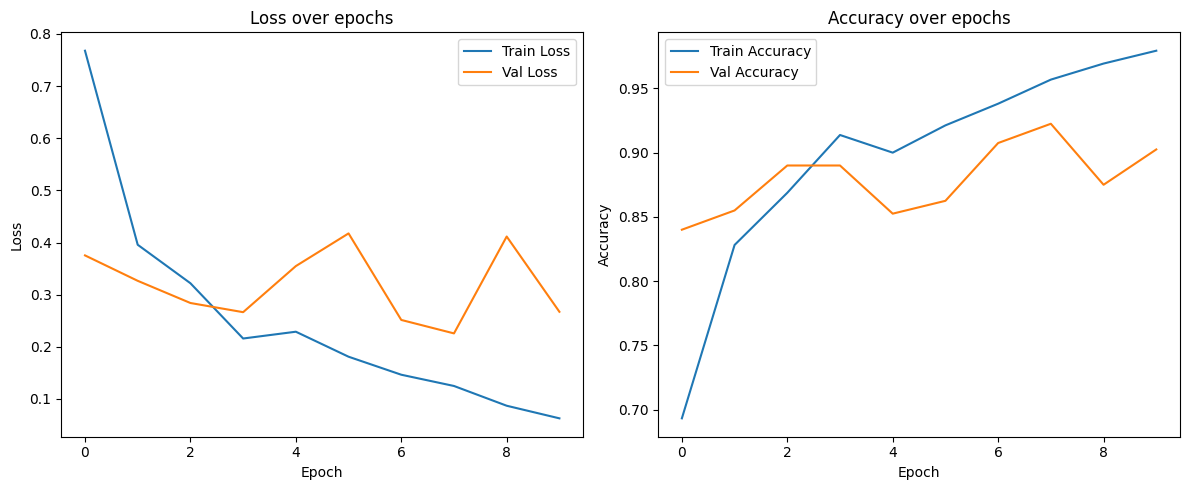

Evaluating: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


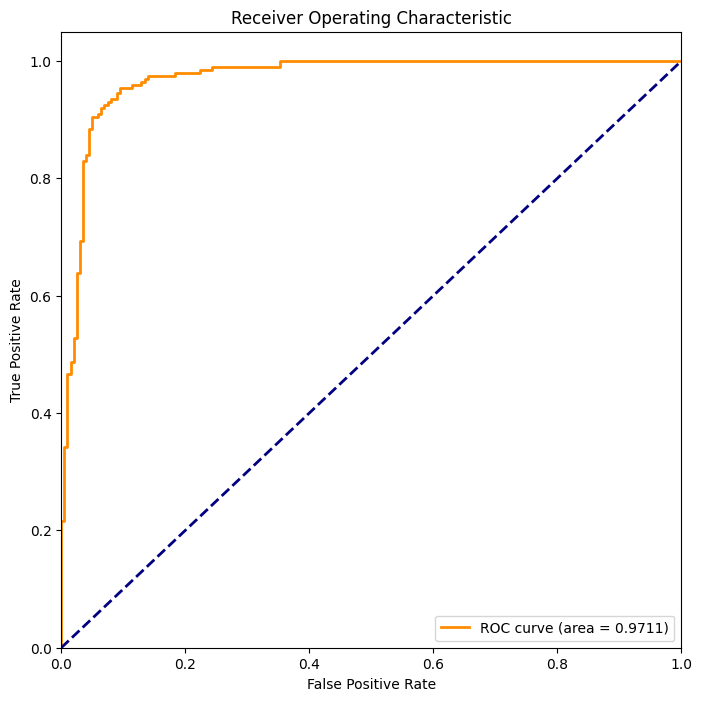

Confusion Matrix:
[[178  23]
 [  8 191]]

Classification Report:
              precision    recall  f1-score   support

 Non-violent       0.96      0.89      0.92       201
     Violent       0.89      0.96      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400


ROC AUC Score: 0.9711


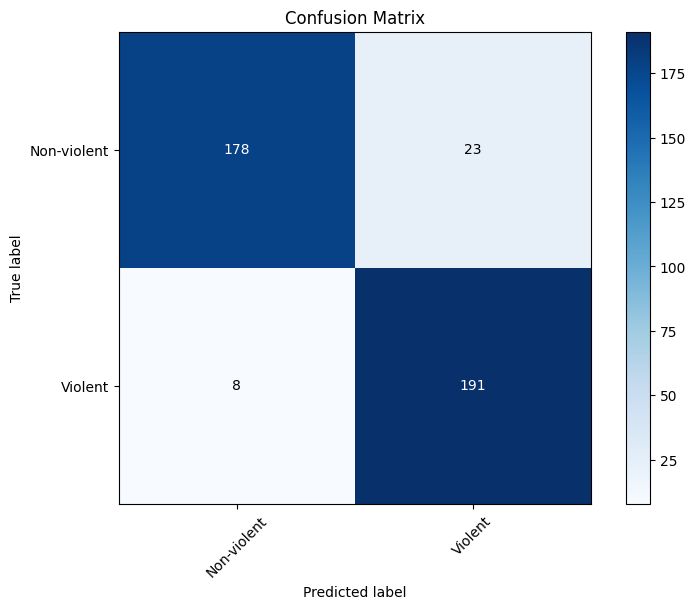

Training completed successfully!
Model saved to: crime_detection_model.keras

Crime Detection Model Deployment Example



Do you want to enter interactive mode to test videos? (y/n):  y



Crime Detection System - Interactive Mode
Model loaded successfully from crime_detection_model.keras

Ready to process videos. Enter 'q' to quit.



Enter the path to the video file:  /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_10.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_10.mp4
Prediction: Non-violent
Confidence: 97.78%


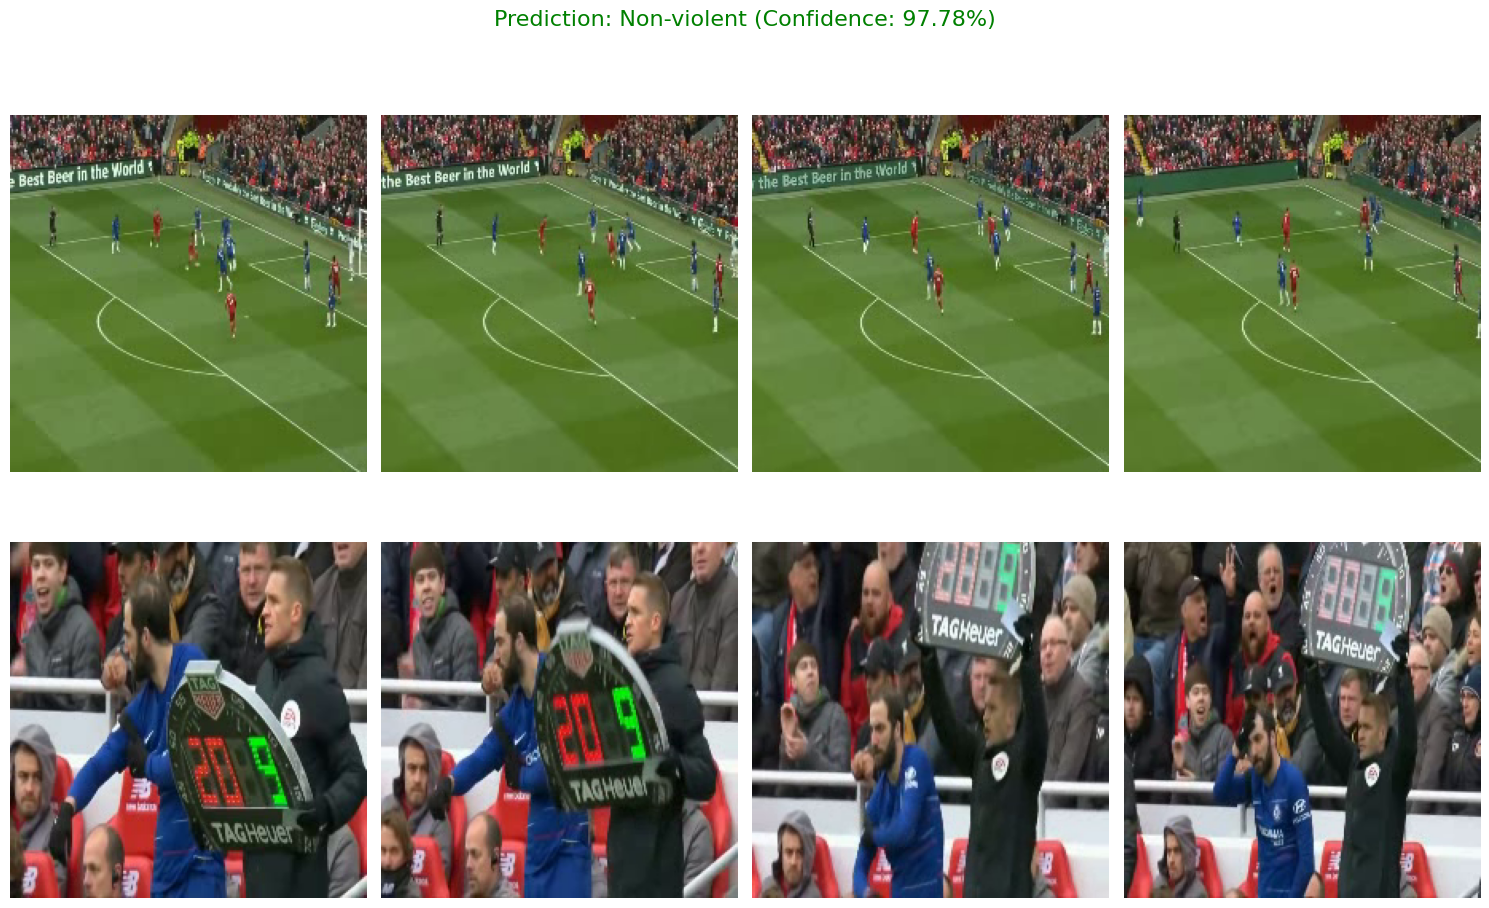


Enter the path to the video file:  /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_100.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_100.mp4
Prediction: Non-violent
Confidence: 99.98%


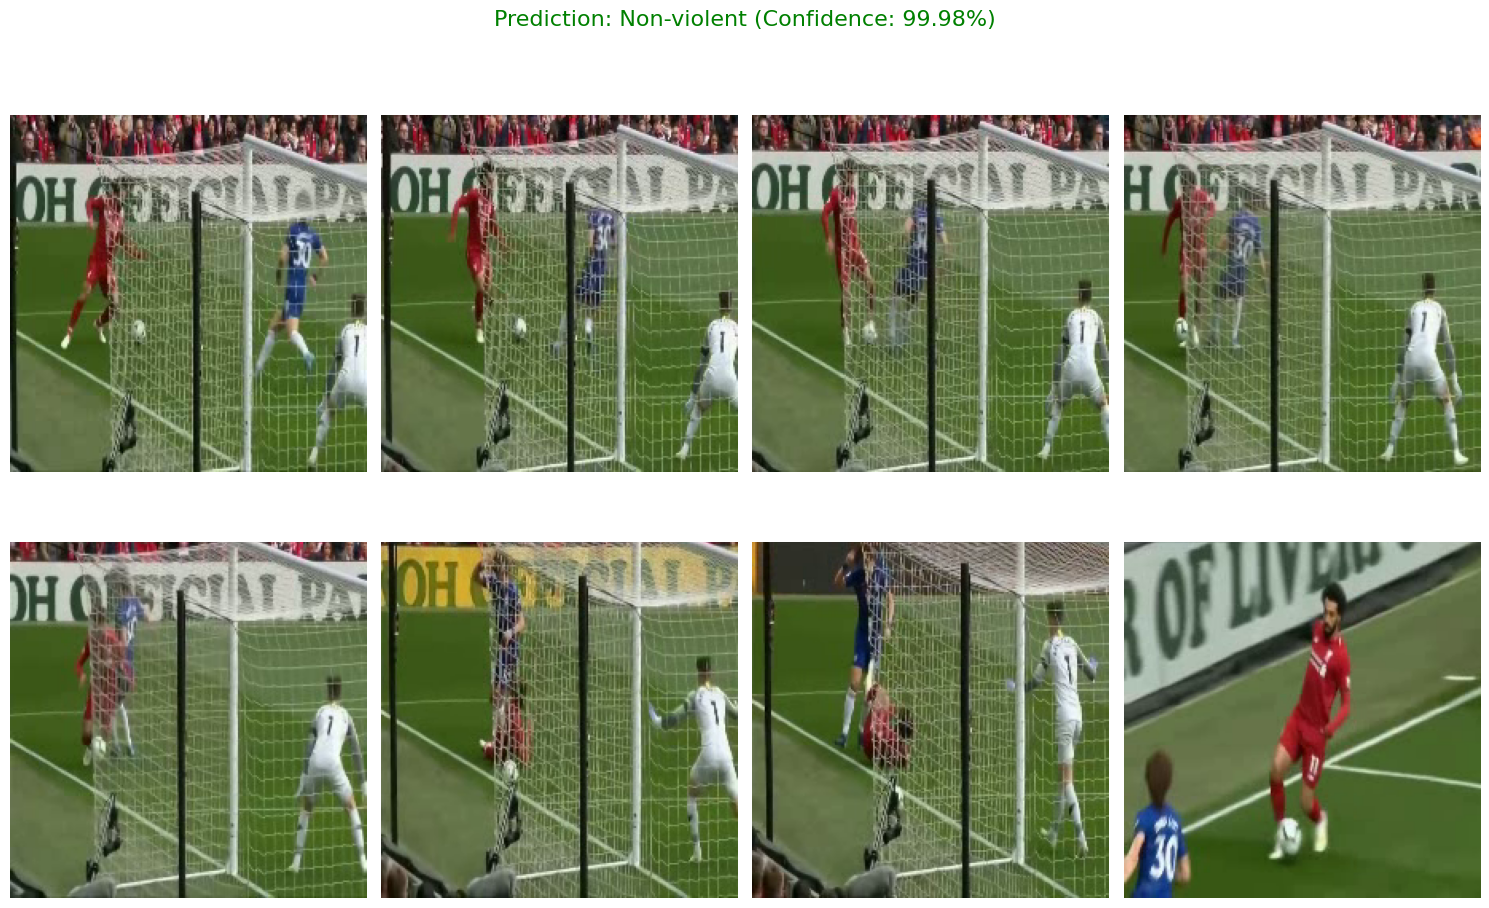


Enter the path to the video file:  /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_109.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_109.mp4
Prediction: Violent
Confidence: 99.91%


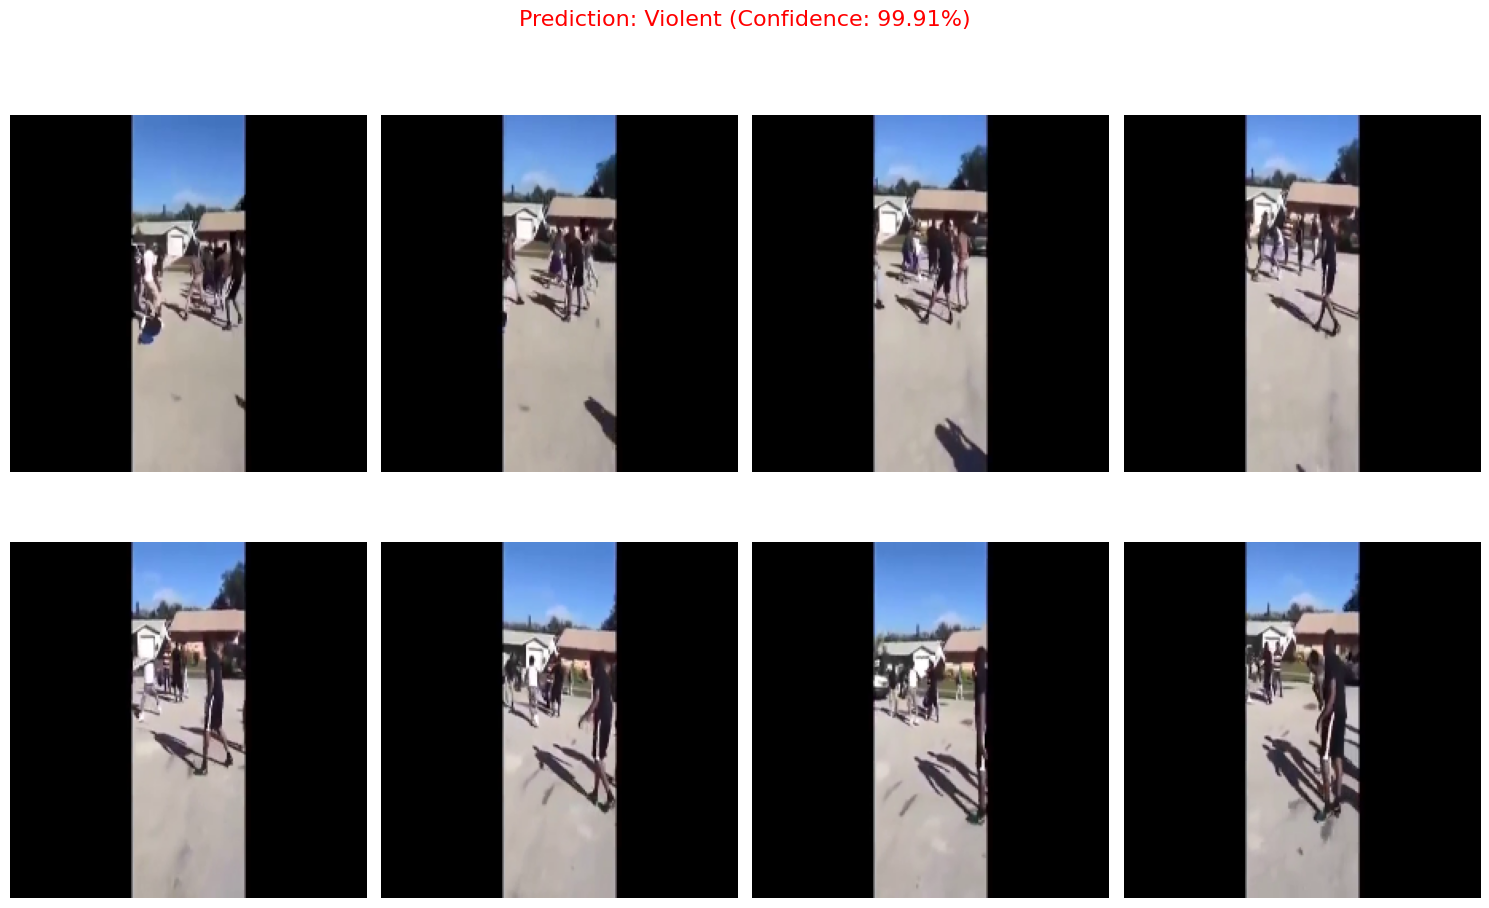


Enter the path to the video file:  /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_210.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_210.mp4
Prediction: Violent
Confidence: 99.91%


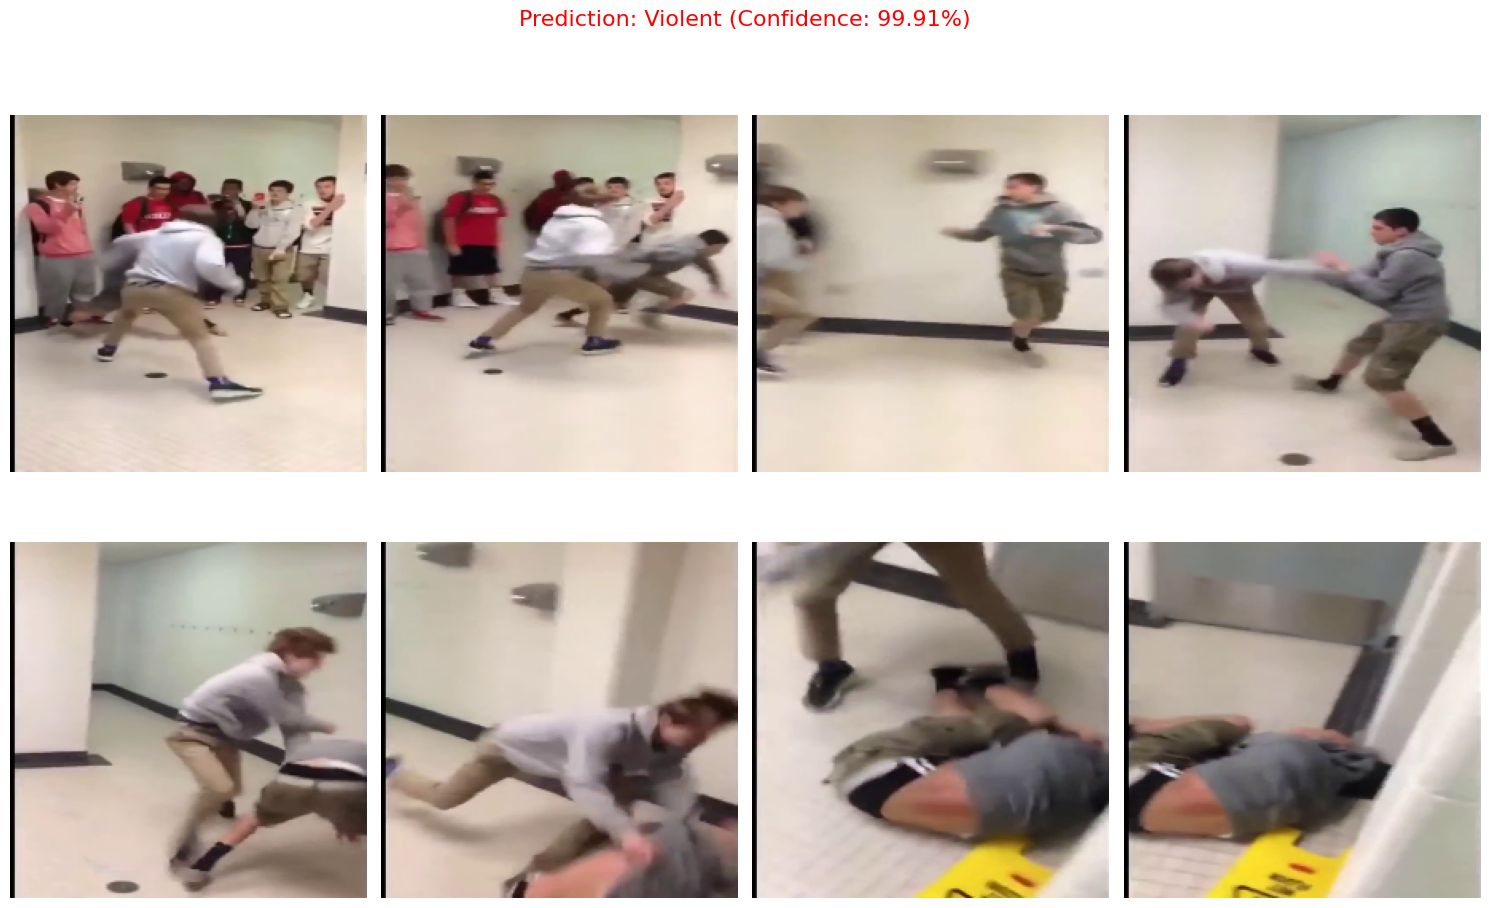

In [ ]:
if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if os.path.exists(DATA_PATH):
        print("Starting model training...")
        model = run_training()
        
        if model is not None:
            print("Training completed successfully!")
            print(f"Model saved to: crime_detection_model.keras")
            
            # Show deployment example
            deploy_model_example()
            
            # Ask if user wants to enter interactive mode
            response = input("\nDo you want to enter interactive mode to test videos? (y/n): ")
            if response.lower() == 'y':
                interactive_mode()
        else:
            print("Training failed. Please check the error messages above.")
    else:
        print("Dataset not found. Please ensure the dataset is available at the specified path.")
        print("Expected path: ", DATA_PATH)
        
        # Check if a pre-trained model exists
        if os.path.exists('crime_detection_model.keras'):
            print("Pre-trained model found. You can still use the model for inference.")
            response = input("Do you want to enter interactive mode to test videos? (y/n): ")
            if response.lower() == 'y':
                interactive_mode()